In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
from datetime import datetime
import copy

In [95]:
np.random.seed(15)
seed = 15
def rmse(y_pred,y_true):
    return sqrt(mean_squared_error(y_pred,y_true))

# 2. import data

In [96]:
sale_data = pd.read_csv('../data/product_quantity.txt', parse_dates=[1])

test_data = pd.read_csv('../data/prediction_lilei_20170320（提交样例）.txt', parse_dates=[1])

info_data = pd.read_csv('../data/product_info.txt')

In [97]:
# info_data[info_data.startdate=='-1'] the missing value is '-1'(string)
# the parse_dates didn't work, do it mannually
info_data.replace('-1', np.nan, inplace=True)
for i in ['startdate', 'upgradedate','cooperatedate']:
    info_data[i] = pd.to_datetime(info_data[i])
sale_data.replace(-1, np.nan, inplace=True)
info_data.replace(-1, np.nan, inplace=True)# if replace with np.nan, the nan would changed to -1 when being transformed to category

In [98]:
no_sales_prod = set(info_data.product_id.values)-set(sale_data.product_id.unique())

## 2.1 deal the sale data and the test data

In [99]:
# join the train and test data for handling together
test_data = test_data.rename(columns={'product_month':'year_month'}).drop('ciiquantity_month', axis=1)

In [100]:
# dorp  the columns that not contained in the data to be predicted
sale_data = sale_data.sort_values(['product_id', 'product_date'])
# sale_data = sale_data.sort_values(['product_id', 'product_date'])

In [101]:
sale_data['year_month']  = sale_data['product_date'].map(lambda x:datetime(x.year,x.month,1))

In [102]:
sale_data['month']  = sale_data['product_date'].apply(lambda x: x.month)

### 月销量聚合

In [103]:
all_cii_data = sale_data.groupby(['product_id', 'year_month'])['ciiquantity'].sum().reset_index()

In [104]:
all_data = all_cii_data.merge(test_data,on=['product_id', 'year_month'], how='outer')


# info data handling

### categorize products according to the voters

In [105]:
info_data['citycenter_1']=np.zeros((4000,1))
info_data['citycenter_2']=np.zeros((4000,1))
info_data.loc[info_data.citycenter.notnull(),'citycenter_1']=1
info_data.loc[info_data.citycenter2.notnull(),'citycenter_2']=1
###对一级城市中心进行进一步划分
info_data.loc[(info_data.citycenter_1 == 1) & (info_data.voters >1400) & (info_data.voters <4100),'citycenter_1']=2
info_data.loc[(info_data.citycenter_1 == 1) & (info_data.voters >=4100) ,'citycenter_1']=3

###对二级城市中心进行进一步划分
info_data.loc[(info_data.citycenter_2 == 1) & (info_data.voters >1850) & (info_data.voters <4600),'citycenter_2']=2
info_data.loc[(info_data.citycenter_2 == 1) & (info_data.voters >=4600) ,'citycenter_2']=3


### handle the start,upgrade,cooperate date

In [106]:
####携程公司1999年成立，因此认为时间早于1999年的均为缺失值######
basetime = pd.to_datetime('1999-01-01')
uptime = pd.to_datetime('2015-11-01')
# info_data.ix[info_data['startdate'] < basetime,'start_date'] = pd.to_datetime(np.NaN)
info_data['start_date'] = info_data['startdate'].apply(lambda x: pd.to_datetime(np.NaN) if ((x < basetime)|(x > uptime)) else x)
info_data['upgrade_date'] = info_data['upgradedate'].apply(lambda x: pd.to_datetime(np.NaN) if ((x < basetime)|(x > uptime)) else x)
info_data['cooperate_date'] = info_data['cooperatedate'].apply(lambda x: pd.to_datetime(np.NaN) if ((x < basetime)|(x > uptime)) else x)
####携程公司1999年成立，因此认为时间早于1999年的均为缺失值######


### add the order_attribute1

In [107]:
product_quantity_feat = sale_data.groupby('product_id').mean()['orderattribute1'].reset_index()

In [108]:
info_data = pd.merge(info_data, product_quantity_feat, on = 'product_id', how = 'left')
##暂时要平均值 2 进行填充
#info_data.orderattribute1 = info_data.orderattribute1.fillna(2)

##后期可根据原始的数据分布进行填充，即缺失分布符合整体数据分布(505个缺失)
idList = [1] * 203 + [2] * 129 + [3] * 173
np.random.shuffle(idList)
idLength = len(idList)

feat_null=info_data.index[info_data.orderattribute1.isnull()].tolist()

for i in range(idLength):
    info_data.loc[info_data.product_id == feat_null[i], 'orderattribute1'] = idList[i]
    

feat = pd.get_dummies(info_data.orderattribute1, prefix = 'feat')
feat['product_id'] = info_data.product_id
info_data = pd.merge(info_data, feat, on = 'product_id', how = 'left')
info_data = info_data.drop('orderattribute1', axis = 1)


In [109]:
# another way

In [110]:
sale_data= pd.get_dummies(sale_data,columns=['orderattribute1','orderattribute2','orderattribute3','orderattribute4'])

# the attr value proportions
OA_list=['orderattribute1_1','orderattribute1_2','orderattribute1_3',
  'orderattribute2_1','orderattribute2_2',
  'orderattribute3_1','orderattribute3_2',
  'orderattribute4_1','orderattribute4_2']
OA_name = ['OA_11','OA_12','OA_13','OA_21','OA_22','OA_31','OA_32','OA_41','OA_42']
sale_count = sale_data.groupby(['product_id']).count()['ciiquantity']
attr_data = pd.DataFrame(sale_data.product_id.unique()).rename(columns={0:'product_id'})
for i in range(len(OA_list)):
    attr_data[OA_name[i]] = np.round((sale_data.groupby(['product_id']).sum()[OA_list[i]]/sale_count).values, 2)

### 缺失值填充

In [111]:
###########对 info_data 中的数据进行整理#######

#####填充缺失值###
info_data['F_set2_lat'] = info_data['lat'].fillna(info_data['lat'].mean())
info_data['F_set2_lon'] = info_data['lon'].fillna(info_data['lon'].mean())
info_data['F_set2_eval2'] = info_data['eval2'].fillna(info_data['eval2'].mean())
info_data['F_set2_eval3'] = info_data['eval3'].fillna(info_data['eval3'].mean())
info_data['F_set2_eval4'] = info_data['eval4'].fillna(info_data['eval4'].mean())

## 库存和投票分布差异巨大，采用中位数进行填充
info_data['F_set2_maxstock']= info_data['maxstock'].fillna(info_data['maxstock'].median())

info_data['F_set2_voters'] = info_data['voters'].fillna(info_data['voters'].median())

In [112]:
info_data['lat'] = info_data['lat'].fillna(method='ffill')
info_data['lon'] = info_data['lon'].fillna(method='ffill')

In [113]:
cate_fill = ['district_id1', 'district_id2', 'district_id3', 'district_id4']
mean_fill = ['eval2','eval3','eval4', 'voters','maxstock']
for i in cate_fill:
    info_data[i] = info_data[i].astype('category').cat.codes
info_data[mean_fill] = info_data[mean_fill].apply(lambda x: x.fillna(x.median()), axis=0)

### voters category

In [114]:
##对Voters 中提取特征，分为5类
info_data['voters_1']=np.zeros((4000,1))
info_data['voters_2']=np.zeros((4000,1))
info_data['voters_3']=np.zeros((4000,1))
info_data['voters_4']=np.zeros((4000,1))
info_data['voters_5']=np.zeros((4000,1))

####分类#####
info_data.loc[info_data.voters<450,'voters_1']=1
info_data.loc[(info_data.voters>=450)&(info_data.voters<1000),'voters_2']=1
info_data.loc[(info_data.voters>=1000)&(info_data.voters<2000),'voters_3']=1
info_data.loc[(info_data.voters>=2000)&(info_data.voters<10000),'voters_4']=1
info_data.loc[(info_data.voters>=10000),'voters_5']=1


In [115]:
##对maxstock中提取特征，分为6类
info_data['maxstock_1']=np.zeros((4000,1))
info_data['maxstock_2']=np.zeros((4000,1))
info_data['maxstock_3']=np.zeros((4000,1))
info_data['maxstock_4']=np.zeros((4000,1))
info_data['maxstock_5']=np.zeros((4000,1))
info_data['maxstock_6']=np.zeros((4000,1))

####分类#####
info_data.loc[info_data.maxstock<75,'maxstock_1']=1
info_data.loc[(info_data.maxstock>=75)&(info_data.maxstock<127),'maxstock_2']=1
info_data.loc[(info_data.maxstock>=127)&(info_data.maxstock<200),'maxstock_3']=1
info_data.loc[(info_data.maxstock>=200)&(info_data.maxstock<800),'maxstock_4']=1
info_data.loc[(info_data.maxstock>=800)&(info_data.maxstock<1200),'maxstock_5']=1
info_data.loc[(info_data.maxstock>=1200),'maxstock_6']=1



In [116]:
#####---------=对缺失的区域ID2进行填充------##########

id2_null=info_data.index[info_data.district_id2.isnull()].tolist()    #district_id2为空的产品id号
for i in id2_null:
    id3=info_data.district_id3[i]      #id2为空的产品的id3号
    id2_list=list(set(info_data.district_id2.ix[info_data.district_id3==id3].tolist()))   #根据id3找到id2的所有可能取值
    id2_array=np.array(id2_list)
    id2_array=id2_array[~np.isnan(id2_array)]   #去掉NaN的id2
    info_data.loc[i,'district_id2']=id2_array[0]    #对空的id2赋值

#####---------=对产品的区域ID进行分类，提取特征------##########

###----id1------划分####

id1_sum=info_data.district_id1.value_counts()
#id1_sum.describe()
#id1_sum.value_counts()
id1_class1=id1_sum[id1_sum>100].index.tolist()
id1_class2=id1_sum[(id1_sum>10)&(id1_sum<=100)].index.tolist()
id1_class3=id1_sum[(id1_sum>0)&(id1_sum<=10)].index.tolist()

info_data['class_id1_1']=np.zeros((4000,1))
info_data['class_id1_2']=np.zeros((4000,1))
info_data['class_id1_3']=np.zeros((4000,1))

for i in id1_class1:
    info_data.loc[info_data.district_id1==i,'class_id1_1']=1

for i in id1_class2:
    info_data.loc[info_data.district_id1==i,'class_id1_2']=1

for i in id1_class3:
    info_data.loc[info_data.district_id1==i,'class_id1_3']=1

#####只将结果分为两类
####info_data.loc[info_data.district_id1==10201,'class_id1']=1

###----id2------划分####
id2_sum=info_data.district_id2.value_counts()
#id2_sum.describe()
#id2_sum.value_counts()
id2_class1=id2_sum[id2_sum>500].index.tolist()
id2_class2=id2_sum[(id2_sum>100)&(id2_sum<=500)].index.tolist()
id2_class3=id2_sum[(id2_sum>0)&(id2_sum<=100)].index.tolist()

info_data['class_id2_1']=np.zeros((4000,1))
info_data['class_id2_2']=np.zeros((4000,1))
info_data['class_id2_3']=np.zeros((4000,1))

for i in id2_class1:
    info_data.loc[info_data.district_id2==i,'class_id2_1']=1

for i in id2_class2:
    info_data.loc[info_data.district_id2==i,'class_id2_2']=1

for i in id2_class3:
    info_data.loc[info_data.district_id2==i,'class_id2_3']=1
    
###----id3------划分####
    
id3_sum=info_data.district_id3.value_counts()
#id3_sum.describe()
#id3_sum.value_counts()
id3_class1=id3_sum[id3_sum>160].index.tolist()
id3_class2=id3_sum[(id3_sum>10)&(id3_sum<=160)].index.tolist()
id3_class3=id3_sum[(id3_sum>0)&(id3_sum<=10)].index.tolist()

info_data['class_id3_1']=np.zeros((4000,1))
info_data['class_id3_2']=np.zeros((4000,1))
info_data['class_id3_3']=np.zeros((4000,1))

for i in id3_class1:
    info_data.loc[info_data.district_id3==i,'class_id3_1']=1

for i in id3_class2:
    info_data.loc[info_data.district_id3==i,'class_id3_2']=1

for i in id3_class3:
    info_data.loc[info_data.district_id3==i,'class_id3_3']=1

### location clustering

In [117]:
from sklearn.cluster import KMeans
k_means_lat_lon = KMeans(n_clusters=9, random_state=seed)
k_means_lat_lon.fit(info_data[['lat', 'lon']])
info_data['location_label'] = k_means_lat_lon.labels_

In [118]:
info_data = info_data.merge(attr_data, on='product_id', how= 'left')

### 聚类，将无销量的505个产品的订单属性特征以类内产品的均值替代

In [119]:

# only use the numerical data
used_columns = ['product_id','lat', 'lon','eval', 'eval2', 'eval3','eval4', 'voters','maxstock']
cluster_data = info_data[used_columns]

cluster_data.head()

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cluster_data.loc[:,['eval', 'eval2', 'eval3','eval4']] = scaler.fit_transform(cluster_data.loc[:,['eval', 'eval2', 'eval3','eval4']])

no_sales_prod = set(info_data.product_id.values)-set(sale_data.product_id.unique())
train_cluster_data = cluster_data[cluster_data.product_id.isin(sale_data.product_id.unique())]
test_cluster_data = cluster_data[cluster_data.product_id.isin(no_sales_prod)]


e:\programs\coding\lang\python35\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [120]:
# cluster the train data to 505
k_means_model = KMeans(n_clusters=505, random_state=seed)
k_means_model.fit(train_cluster_data[['lat', 'lon','eval', 'eval2', 'eval3','eval4', 'voters','maxstock']])

train_cluster_data['c_label'] = k_means_model.labels_

test_cluster_data['c_label'] = k_means_model.predict(test_cluster_data[['lat', 'lon','eval', 'eval2', 'eval3','eval4', 'voters','maxstock']])

label_data = train_cluster_data[['product_id', 'c_label']].append(test_cluster_data[['product_id', 'c_label']])

info_data = info_data.merge(label_data, on='product_id')

e:\programs\coding\lang\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
e:\programs\coding\lang\python35\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### use clabel to fill the missing values in order attributes

In [121]:
# for attribute1 fill with the mode, cause it is binary value, as for others, use the mean
attr_1 = ['OA_11','OA_12','OA_13']
attr_234 = ['OA_21','OA_22','OA_31','OA_32','OA_41','OA_42']

In [122]:
def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

In [123]:
attr_mode =info_data[info_data.product_id.isin(sale_data.product_id.unique())].groupby('c_label')[attr_1].agg(mode).reset_index()
attr_mean =info_data[info_data.product_id.isin(sale_data.product_id.unique())].groupby('c_label').mean()[attr_234].reset_index()

In [124]:
attr_mean =attr_mean.merge(attr_mode, on='c_label', how='left')

id_c_label = ['product_id','c_label']
missing_attr = info_data.ix[info_data.product_id.isin(no_sales_prod),id_c_label].merge(attr_mean,on='c_label',how='inner').sort_values('product_id')

info_data.ix[info_data.product_id.isin(no_sales_prod),OA_name] = missing_attr.ix[:,OA_name].values


#  merge the sale data and the info_data

In [125]:
all_data = all_data.merge(info_data,on='product_id',how='left')

### fill the cii of those 505 products in order to use them as samples

In [126]:
fill_505 = all_data.groupby(['c_label', 'year_month'])['ciiquantity'].mean().reset_index().dropna()

In [127]:
data_505 = all_data[all_data.product_id.isin(no_sales_prod)][['product_id', 'c_label']].drop_duplicates()

In [128]:
data_505 = data_505.merge(fill_505, on='c_label', how='left')

In [129]:
data_505 = data_505.merge(info_data, on=['product_id','c_label'],how='left')

In [130]:
all_data = all_data.append(data_505)

In [131]:
all_data['month'] = all_data['year_month'].apply(lambda x:x.month).astype('category').cat.codes

# 3. Features

### 将三个时间特征中2000年以前的转换为2000年（主要是处理缺失值和异常值--1753-1-1）

In [132]:
#######################################################################
# set these whose start date, upgrade date, cooperate date are before 2000 as 2000.and fill the nat as 2005 too
threshold_year = pd.to_datetime('2000-01-01')
for i in ['startdate','upgradedate','cooperatedate']:
    all_data[i] = all_data[i].apply(lambda x: threshold_year if ((x < threshold_year)| pd.isnull(x)) else x)

### 时间跨度特征: product_date - upgrade_date, product_date-startdate, 转换成月份

In [133]:
all_data['sale2start_time_delta'] = (all_data['year_month']-all_data['startdate']).apply(lambda x: x.days/30 if x.days>0 else 0 )
all_data['sale2upgrade_time_delta'] = (all_data['year_month']-all_data['upgradedate']).apply(lambda x: x.days/30 if x.days>0 else 0)
all_data['sale2cooperate_time_delta'] = (all_data['year_month']-all_data['cooperatedate']).apply(lambda x: x.days/30 if x.days>0 else 0)

### 假日特征

In [134]:
holiday_num={'2014-01-01':8,'2014-02-01':11,'2014-03-01':10,'2014-04-01':9,'2014-05-01':10,'2014-06-01':10,
              '2014-07-01':8,'2014-08-01':10,'2014-09-01':8,'2014-10-01':12,'2014-11-01':10,'2014-12-01':8,
              '2015-01-01':9,'2015-02-01':11,'2015-03-01':8,'2015-04-01':9,'2015-05-01':11,'2015-06-01':9,
              '2015-07-01':8,'2015-08-01':10,'2015-09-01':9,'2015-10-01':13,'2015-11-01':9,'2015-12-01':8,
              '2016-01-01':11,'2016-02-01':11,'2016-03-01':8,'2016-04-01':10,'2016-05-01':10,'2016-06-01':9,
              '2016-07-01':10,'2016-08-01':8,'2016-09-01':8,'2016-10-01':13,'2016-11-01':8,'2016-12-01':9,
              '2017-01-01':12}
all_data['year_month_str'] = all_data['year_month'].astype(str)
all_data['holiday_num'] = all_data['year_month_str'].map(holiday_num)
all_data = all_data.drop('year_month_str', axis=1)

### transform dummies for location and month

In [135]:
all_data =pd.get_dummies(all_data,columns=['location_label', 'month'])

In [136]:
all_data['month'] = all_data['year_month'].apply(lambda x: x.month)

### basetime

In [137]:
def diffMonth(endDate):  
    startDate=datetime(2013,12,1)
    startYear=startDate.year  
    startMonth=startDate.month  
    endYear=endDate.year  
    endMonth=endDate.month  
    #如果是同年  
    if startYear==endYear:  
        diffmonths=endMonth-startMonth  
    #如果是上年  
    elif endYear-startYear==1:  
        diffmonths=12+endMonth-startMonth  
    #如果是大于1年  
    elif endYear-startYear>1:  
        years=endYear-startYear  
        diffmonths=(years-1)*12+12+endMonth-startMonth  
    #如果开始日期大约结束日期报错  
    elif endYear-startYear<0 or( endYear==startYear and endMonth-startMonth):  
        print('enddate must greater than startdate')
    return int(diffmonths)

all_data['base_time']=all_data['year_month'].apply(diffMonth)

## set the weights for each samples(2014 and 2015)

In [138]:
all_data['sample_weight'] = all_data['year_month'].apply(lambda x: 0.7 if x.year==2015 else 0.3)

#  4. model

### 特征集

In [139]:
feature_set1 = ['ciiquantity', 'month','district_id1','district_id2','district_id3',
                'maxstock','district_id4','eval', 'eval2', 'eval3','eval4','voters',
               'sale2start_time_delta','sale2upgrade_time_delta','sale2cooperate_time_delta']
feature_set2 = copy.deepcopy(feature_set1)
feature_set2.extend(['OA_11', 'OA_12', 'OA_13'])

feature_set3 = copy.deepcopy(feature_set1)
feature_set3.extend(['lat', 'lon', 'product_id', 'holiday_num'])

feature_set4 = ['ciiquantity','product_id', 'F_set2_lat', 'F_set2_lon', 'eval', 'F_set2_eval2', 'F_set2_eval3', 'F_set2_eval4',
               'citycenter_1', 'citycenter_2', 'feat_1.0', 'feat_2.0', 'feat_3.0',
               'voters_1', 'voters_2', 'voters_3', 'voters_4', 'voters_5',
               'maxstock_1', 'maxstock_2', 'maxstock_3', 'maxstock_4', 'maxstock_5',
               'maxstock_6', 'class_id1_1', 'class_id1_2', 'class_id1_3',
               'sale2cooperate_time_delta', 'sale2start_time_delta', 'holiday_num', 'base_time', 'location_label_0',
               'location_label_1', 'location_label_2', 'location_label_3', 'location_label_4', 'location_label_5',
               'location_label_6', 'location_label_7', 'location_label_8', 'month_0', 'month_1',
               'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
               'month_8', 'month_9', 'month_10', 'month_11']


features = [feature_set2,feature_set3, feature_set4]


## 数据集划分（训练集，验证集，测试集）

In [140]:
temp_data = all_data
i=0
tr = temp_data[temp_data['year_month'] < pd.to_datetime('2015-01-01')][features[i]]
vd = temp_data[(temp_data['year_month'] < pd.to_datetime('2015-12-01')) & (temp_data['year_month']> pd.to_datetime('2014-12-01'))][features[i]]
tr_x = tr.drop('ciiquantity',axis=1)
tr_y = tr['ciiquantity'].fillna(0)
vd_x = vd.drop('ciiquantity',axis=1)
vd_y = vd['ciiquantity'].fillna(0)
test = temp_data[temp_data['year_month'] >= pd.to_datetime('2015-12-01')][features[i]]
test_x = test.drop('ciiquantity',axis=1)

## 4.2 models

### 4.2.1 XGB

In [141]:
import xgboost as xgb
# normal way
xgb_train = xgb.DMatrix(tr_x, tr_y)
xgb_valid = xgb.DMatrix(vd_x, vd_y)

xgb_params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.1,
              "max_depth": 6,
              "subsample": 0.8,
              "colsample_bytree": 0.6,
              "min_child_weight": 1,
              'gamma':3,
              'lambda':1,
              "silent": 0,
              "thread":-1,
              "seed": seed
              }
num_boost_round = 1500
watchlist = [(xgb_train, 'train'), (xgb_valid, 'eval')]
# xgb_model =xgb.cv(xgb_params,xgb_train,num_boost_round,nfold=5, verbose_eval=True, early_stopping_rounds=300)
xgb_model =xgb.train(xgb_params,xgb_train,num_boost_round,evals =watchlist, verbose_eval=True, early_stopping_rounds=1300)

[0]	train-rmse:221.981	eval-rmse:287.418
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 1300 rounds.
[1]	train-rmse:210.848	eval-rmse:277.573
[2]	train-rmse:196.188	eval-rmse:264.788
[3]	train-rmse:185.206	eval-rmse:254.959
[4]	train-rmse:177.007	eval-rmse:247.289
[5]	train-rmse:170.306	eval-rmse:241.065
[6]	train-rmse:161.88	eval-rmse:233.521
[7]	train-rmse:156.493	eval-rmse:228.464
[8]	train-rmse:151.049	eval-rmse:223.339
[9]	train-rmse:143.946	eval-rmse:217.117
[10]	train-rmse:137.493	eval-rmse:211.304
[11]	train-rmse:134.686	eval-rmse:208.331
[12]	train-rmse:129.246	eval-rmse:203.204
[13]	train-rmse:124.917	eval-rmse:199.453
[14]	train-rmse:122.376	eval-rmse:197.162
[15]	train-rmse:118.652	eval-rmse:193.872
[16]	train-rmse:115.99	eval-rmse:191.356
[17]	train-rmse:113.799	eval-rmse:189.392
[18]	train-rmse:112.387	eval-rmse:187.929
[19]	train-rmse:110.032	eval-rmse:185.656
[20]	train-rmse:109.159	eva

[191]	train-rmse:65.9656	eval-rmse:161.145
[192]	train-rmse:65.8814	eval-rmse:161.135
[193]	train-rmse:65.8179	eval-rmse:161.159
[194]	train-rmse:65.7632	eval-rmse:161.146
[195]	train-rmse:65.6725	eval-rmse:161.147
[196]	train-rmse:65.4869	eval-rmse:161.071
[197]	train-rmse:65.4529	eval-rmse:161.067
[198]	train-rmse:65.3885	eval-rmse:161.051
[199]	train-rmse:65.2922	eval-rmse:161.023
[200]	train-rmse:65.1825	eval-rmse:161.041
[201]	train-rmse:65.1284	eval-rmse:161.068
[202]	train-rmse:65.0057	eval-rmse:161.023
[203]	train-rmse:64.9143	eval-rmse:161.024
[204]	train-rmse:64.7987	eval-rmse:161.013
[205]	train-rmse:64.7526	eval-rmse:161.014
[206]	train-rmse:64.649	eval-rmse:161.036
[207]	train-rmse:64.5787	eval-rmse:161.046
[208]	train-rmse:64.4598	eval-rmse:160.953
[209]	train-rmse:64.399	eval-rmse:160.931
[210]	train-rmse:64.334	eval-rmse:160.941
[211]	train-rmse:64.1976	eval-rmse:160.943
[212]	train-rmse:64.1148	eval-rmse:160.948
[213]	train-rmse:64.0267	eval-rmse:160.924
[214]	train-rm

[383]	train-rmse:53.8169	eval-rmse:160.302
[384]	train-rmse:53.7844	eval-rmse:160.314
[385]	train-rmse:53.7069	eval-rmse:160.323
[386]	train-rmse:53.6802	eval-rmse:160.304
[387]	train-rmse:53.6467	eval-rmse:160.3
[388]	train-rmse:53.5805	eval-rmse:160.342
[389]	train-rmse:53.548	eval-rmse:160.328
[390]	train-rmse:53.5291	eval-rmse:160.3
[391]	train-rmse:53.4766	eval-rmse:160.362
[392]	train-rmse:53.418	eval-rmse:160.366
[393]	train-rmse:53.3853	eval-rmse:160.374
[394]	train-rmse:53.3628	eval-rmse:160.363
[395]	train-rmse:53.3369	eval-rmse:160.366
[396]	train-rmse:53.289	eval-rmse:160.36
[397]	train-rmse:53.2249	eval-rmse:160.331
[398]	train-rmse:53.1786	eval-rmse:160.341
[399]	train-rmse:53.1585	eval-rmse:160.345
[400]	train-rmse:53.0729	eval-rmse:160.324
[401]	train-rmse:53.0067	eval-rmse:160.309
[402]	train-rmse:52.9149	eval-rmse:160.299
[403]	train-rmse:52.8655	eval-rmse:160.315
[404]	train-rmse:52.8159	eval-rmse:160.337
[405]	train-rmse:52.789	eval-rmse:160.344
[406]	train-rmse:52.

[575]	train-rmse:46.3867	eval-rmse:160.283
[576]	train-rmse:46.3416	eval-rmse:160.271
[577]	train-rmse:46.3081	eval-rmse:160.245
[578]	train-rmse:46.2818	eval-rmse:160.245
[579]	train-rmse:46.2712	eval-rmse:160.241
[580]	train-rmse:46.2528	eval-rmse:160.257
[581]	train-rmse:46.2184	eval-rmse:160.247
[582]	train-rmse:46.1836	eval-rmse:160.241
[583]	train-rmse:46.1553	eval-rmse:160.242
[584]	train-rmse:46.1445	eval-rmse:160.237
[585]	train-rmse:46.0936	eval-rmse:160.266
[586]	train-rmse:46.0267	eval-rmse:160.266
[587]	train-rmse:46.0111	eval-rmse:160.276
[588]	train-rmse:45.9744	eval-rmse:160.259
[589]	train-rmse:45.9341	eval-rmse:160.264
[590]	train-rmse:45.915	eval-rmse:160.263
[591]	train-rmse:45.881	eval-rmse:160.238
[592]	train-rmse:45.8316	eval-rmse:160.228
[593]	train-rmse:45.7904	eval-rmse:160.219
[594]	train-rmse:45.7522	eval-rmse:160.226
[595]	train-rmse:45.7312	eval-rmse:160.226
[596]	train-rmse:45.6919	eval-rmse:160.247
[597]	train-rmse:45.6658	eval-rmse:160.246
[598]	train-r

[767]	train-rmse:41.0757	eval-rmse:160.324
[768]	train-rmse:41.0574	eval-rmse:160.334
[769]	train-rmse:41.0324	eval-rmse:160.334
[770]	train-rmse:41.0111	eval-rmse:160.345
[771]	train-rmse:40.9903	eval-rmse:160.354
[772]	train-rmse:40.9716	eval-rmse:160.356
[773]	train-rmse:40.9479	eval-rmse:160.351
[774]	train-rmse:40.9232	eval-rmse:160.346
[775]	train-rmse:40.8899	eval-rmse:160.353
[776]	train-rmse:40.8689	eval-rmse:160.345
[777]	train-rmse:40.8374	eval-rmse:160.349
[778]	train-rmse:40.8099	eval-rmse:160.342
[779]	train-rmse:40.7862	eval-rmse:160.362
[780]	train-rmse:40.7703	eval-rmse:160.371
[781]	train-rmse:40.7515	eval-rmse:160.391
[782]	train-rmse:40.7308	eval-rmse:160.397
[783]	train-rmse:40.7044	eval-rmse:160.401
[784]	train-rmse:40.6754	eval-rmse:160.412
[785]	train-rmse:40.653	eval-rmse:160.413
[786]	train-rmse:40.6363	eval-rmse:160.408
[787]	train-rmse:40.6142	eval-rmse:160.4
[788]	train-rmse:40.5978	eval-rmse:160.391
[789]	train-rmse:40.5878	eval-rmse:160.396
[790]	train-rm

[959]	train-rmse:37.1605	eval-rmse:160.477
[960]	train-rmse:37.1418	eval-rmse:160.471
[961]	train-rmse:37.1329	eval-rmse:160.47
[962]	train-rmse:37.1215	eval-rmse:160.48
[963]	train-rmse:37.1179	eval-rmse:160.48
[964]	train-rmse:37.0859	eval-rmse:160.49
[965]	train-rmse:37.0684	eval-rmse:160.488
[966]	train-rmse:37.0503	eval-rmse:160.5
[967]	train-rmse:37.014	eval-rmse:160.494
[968]	train-rmse:36.994	eval-rmse:160.495
[969]	train-rmse:36.977	eval-rmse:160.481
[970]	train-rmse:36.9646	eval-rmse:160.5
[971]	train-rmse:36.9473	eval-rmse:160.509
[972]	train-rmse:36.9307	eval-rmse:160.51
[973]	train-rmse:36.9019	eval-rmse:160.507
[974]	train-rmse:36.8761	eval-rmse:160.509
[975]	train-rmse:36.8553	eval-rmse:160.514
[976]	train-rmse:36.8089	eval-rmse:160.497
[977]	train-rmse:36.789	eval-rmse:160.515
[978]	train-rmse:36.768	eval-rmse:160.515
[979]	train-rmse:36.76	eval-rmse:160.508
[980]	train-rmse:36.7376	eval-rmse:160.52
[981]	train-rmse:36.7233	eval-rmse:160.52
[982]	train-rmse:36.7183	eval

[1148]	train-rmse:34.0587	eval-rmse:160.773
[1149]	train-rmse:34.0518	eval-rmse:160.778
[1150]	train-rmse:34.0326	eval-rmse:160.776
[1151]	train-rmse:34.0251	eval-rmse:160.773
[1152]	train-rmse:34.0093	eval-rmse:160.766
[1153]	train-rmse:33.9945	eval-rmse:160.759
[1154]	train-rmse:33.9844	eval-rmse:160.764
[1155]	train-rmse:33.9746	eval-rmse:160.763
[1156]	train-rmse:33.95	eval-rmse:160.772
[1157]	train-rmse:33.937	eval-rmse:160.785
[1158]	train-rmse:33.918	eval-rmse:160.775
[1159]	train-rmse:33.9143	eval-rmse:160.775
[1160]	train-rmse:33.8978	eval-rmse:160.782
[1161]	train-rmse:33.8705	eval-rmse:160.8
[1162]	train-rmse:33.8507	eval-rmse:160.774
[1163]	train-rmse:33.8478	eval-rmse:160.78
[1164]	train-rmse:33.829	eval-rmse:160.777
[1165]	train-rmse:33.8086	eval-rmse:160.785
[1166]	train-rmse:33.7909	eval-rmse:160.786
[1167]	train-rmse:33.7873	eval-rmse:160.789
[1168]	train-rmse:33.7677	eval-rmse:160.789
[1169]	train-rmse:33.7571	eval-rmse:160.79
[1170]	train-rmse:33.7411	eval-rmse:160.7

[1336]	train-rmse:31.4542	eval-rmse:160.87
[1337]	train-rmse:31.4397	eval-rmse:160.85
[1338]	train-rmse:31.4272	eval-rmse:160.851
[1339]	train-rmse:31.4151	eval-rmse:160.862
[1340]	train-rmse:31.3992	eval-rmse:160.842
[1341]	train-rmse:31.3873	eval-rmse:160.838
[1342]	train-rmse:31.3772	eval-rmse:160.857
[1343]	train-rmse:31.3699	eval-rmse:160.859
[1344]	train-rmse:31.3656	eval-rmse:160.867
[1345]	train-rmse:31.3631	eval-rmse:160.865
[1346]	train-rmse:31.3591	eval-rmse:160.855
[1347]	train-rmse:31.3517	eval-rmse:160.858
[1348]	train-rmse:31.3293	eval-rmse:160.855
[1349]	train-rmse:31.3211	eval-rmse:160.863
[1350]	train-rmse:31.3019	eval-rmse:160.862
[1351]	train-rmse:31.2966	eval-rmse:160.855
[1352]	train-rmse:31.2861	eval-rmse:160.858
[1353]	train-rmse:31.2756	eval-rmse:160.862
[1354]	train-rmse:31.2623	eval-rmse:160.858
[1355]	train-rmse:31.2563	eval-rmse:160.857
[1356]	train-rmse:31.2444	eval-rmse:160.861
[1357]	train-rmse:31.228	eval-rmse:160.861
[1358]	train-rmse:31.2237	eval-rmse

In [142]:
xgb_model.best_iteration

344

In [143]:
xgb_vd_pred = xgb_model.predict(xgb.DMatrix(vd_x))
# xgb_vd_pred = scaler_y.inverse_transform(xgb_vd_pred)
xgb_vd_pred[xgb_vd_pred<0] = 10
xgb_vd_pred = np.round(xgb_vd_pred)
vd_y = vd['ciiquantity'].fillna(0)
rmse_score = rmse(vd_y,xgb_vd_pred)
rmse_score

160.64789266841643

In [144]:
rmse(vd_y,xgb_vd_pred*1.2)

153.18867155968493

### 4.2.2 LGB

In [145]:
import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV

lgb_tr = lgb.Dataset(tr_x, tr_y)
lgb_vd = lgb.Dataset(vd_x, vd_y, reference=lgb_tr)
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'rmse'},
    'num_leaves': 55,
    'learning_rate': 0.1,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'min_data_in_leaf':100,
    'verbose': 1,
    'random_state': seed}
lgb_model = lgb.train(lgb_params, lgb_tr, num_boost_round=5000,valid_sets=lgb_vd, early_stopping_rounds=3500)

[1]	valid_0's l2: 289.851
Train until valid scores didn't improve in 3500 rounds.
[2]	valid_0's l2: 276.246
[3]	valid_0's l2: 264.39
[4]	valid_0's l2: 256.581
[5]	valid_0's l2: 249.817
[6]	valid_0's l2: 243.952
[7]	valid_0's l2: 238.685
[8]	valid_0's l2: 233.523
[9]	valid_0's l2: 226.535
[10]	valid_0's l2: 221.025
[11]	valid_0's l2: 215.767
[12]	valid_0's l2: 213.086
[13]	valid_0's l2: 210.66
[14]	valid_0's l2: 207.35
[15]	valid_0's l2: 205.553
[16]	valid_0's l2: 203.82
[17]	valid_0's l2: 202.146
[18]	valid_0's l2: 200.391
[19]	valid_0's l2: 197.485
[20]	valid_0's l2: 195.515
[21]	valid_0's l2: 194.324
[22]	valid_0's l2: 193.472
[23]	valid_0's l2: 192.573
[24]	valid_0's l2: 190.896
[25]	valid_0's l2: 190.358
[26]	valid_0's l2: 189.48
[27]	valid_0's l2: 187.397
[28]	valid_0's l2: 186.199
[29]	valid_0's l2: 184.876
[30]	valid_0's l2: 184.286
[31]	valid_0's l2: 183.656
[32]	valid_0's l2: 183.095
[33]	valid_0's l2: 182.42
[34]	valid_0's l2: 182.136
[35]	valid_0's l2: 181.418
[36]	valid_0's

[310]	valid_0's l2: 163.953
[311]	valid_0's l2: 163.896
[312]	valid_0's l2: 163.821
[313]	valid_0's l2: 163.79
[314]	valid_0's l2: 163.737
[315]	valid_0's l2: 163.739
[316]	valid_0's l2: 163.669
[317]	valid_0's l2: 163.624
[318]	valid_0's l2: 163.58
[319]	valid_0's l2: 163.451
[320]	valid_0's l2: 163.409
[321]	valid_0's l2: 163.324
[322]	valid_0's l2: 163.253
[323]	valid_0's l2: 163.21
[324]	valid_0's l2: 163.188
[325]	valid_0's l2: 163.12
[326]	valid_0's l2: 163.166
[327]	valid_0's l2: 163.12
[328]	valid_0's l2: 163.081
[329]	valid_0's l2: 163.095
[330]	valid_0's l2: 163.142
[331]	valid_0's l2: 163.152
[332]	valid_0's l2: 163.168
[333]	valid_0's l2: 163.156
[334]	valid_0's l2: 163.144
[335]	valid_0's l2: 163.129
[336]	valid_0's l2: 163.128
[337]	valid_0's l2: 163.101
[338]	valid_0's l2: 163.233
[339]	valid_0's l2: 163.248
[340]	valid_0's l2: 163.312
[341]	valid_0's l2: 163.367
[342]	valid_0's l2: 163.358
[343]	valid_0's l2: 163.426
[344]	valid_0's l2: 163.414
[345]	valid_0's l2: 163.4

[632]	valid_0's l2: 162.032
[633]	valid_0's l2: 162.047
[634]	valid_0's l2: 162.078
[635]	valid_0's l2: 162.055
[636]	valid_0's l2: 162.062
[637]	valid_0's l2: 162.028
[638]	valid_0's l2: 162.005
[639]	valid_0's l2: 161.984
[640]	valid_0's l2: 161.973
[641]	valid_0's l2: 161.963
[642]	valid_0's l2: 161.968
[643]	valid_0's l2: 161.951
[644]	valid_0's l2: 161.95
[645]	valid_0's l2: 161.954
[646]	valid_0's l2: 161.971
[647]	valid_0's l2: 162.011
[648]	valid_0's l2: 162.045
[649]	valid_0's l2: 162.069
[650]	valid_0's l2: 162.057
[651]	valid_0's l2: 162.078
[652]	valid_0's l2: 162.085
[653]	valid_0's l2: 162.099
[654]	valid_0's l2: 162.119
[655]	valid_0's l2: 162.168
[656]	valid_0's l2: 162.11
[657]	valid_0's l2: 162.104
[658]	valid_0's l2: 162.102
[659]	valid_0's l2: 162.077
[660]	valid_0's l2: 162.041
[661]	valid_0's l2: 162.046
[662]	valid_0's l2: 162.019
[663]	valid_0's l2: 161.978
[664]	valid_0's l2: 161.993
[665]	valid_0's l2: 162.034
[666]	valid_0's l2: 162.028
[667]	valid_0's l2: 16

[933]	valid_0's l2: 161.947
[934]	valid_0's l2: 161.967
[935]	valid_0's l2: 161.976
[936]	valid_0's l2: 161.948
[937]	valid_0's l2: 161.991
[938]	valid_0's l2: 162
[939]	valid_0's l2: 162.009
[940]	valid_0's l2: 162.013
[941]	valid_0's l2: 161.941
[942]	valid_0's l2: 161.888
[943]	valid_0's l2: 161.901
[944]	valid_0's l2: 161.884
[945]	valid_0's l2: 161.859
[946]	valid_0's l2: 161.822
[947]	valid_0's l2: 161.81
[948]	valid_0's l2: 161.798
[949]	valid_0's l2: 161.787
[950]	valid_0's l2: 161.768
[951]	valid_0's l2: 161.825
[952]	valid_0's l2: 161.81
[953]	valid_0's l2: 161.816
[954]	valid_0's l2: 161.821
[955]	valid_0's l2: 161.812
[956]	valid_0's l2: 161.791
[957]	valid_0's l2: 161.791
[958]	valid_0's l2: 161.782
[959]	valid_0's l2: 161.778
[960]	valid_0's l2: 161.779
[961]	valid_0's l2: 161.775
[962]	valid_0's l2: 161.737
[963]	valid_0's l2: 161.718
[964]	valid_0's l2: 161.654
[965]	valid_0's l2: 161.645
[966]	valid_0's l2: 161.646
[967]	valid_0's l2: 161.659
[968]	valid_0's l2: 161.63

[1239]	valid_0's l2: 161.397
[1240]	valid_0's l2: 161.393
[1241]	valid_0's l2: 161.433
[1242]	valid_0's l2: 161.431
[1243]	valid_0's l2: 161.377
[1244]	valid_0's l2: 161.404
[1245]	valid_0's l2: 161.399
[1246]	valid_0's l2: 161.354
[1247]	valid_0's l2: 161.281
[1248]	valid_0's l2: 161.276
[1249]	valid_0's l2: 161.264
[1250]	valid_0's l2: 161.185
[1251]	valid_0's l2: 161.203
[1252]	valid_0's l2: 161.232
[1253]	valid_0's l2: 161.235
[1254]	valid_0's l2: 161.235
[1255]	valid_0's l2: 161.244
[1256]	valid_0's l2: 161.267
[1257]	valid_0's l2: 161.345
[1258]	valid_0's l2: 161.364
[1259]	valid_0's l2: 161.374
[1260]	valid_0's l2: 161.409
[1261]	valid_0's l2: 161.424
[1262]	valid_0's l2: 161.399
[1263]	valid_0's l2: 161.384
[1264]	valid_0's l2: 161.37
[1265]	valid_0's l2: 161.362
[1266]	valid_0's l2: 161.367
[1267]	valid_0's l2: 161.369
[1268]	valid_0's l2: 161.35
[1269]	valid_0's l2: 161.335
[1270]	valid_0's l2: 161.328
[1271]	valid_0's l2: 161.37
[1272]	valid_0's l2: 161.402
[1273]	valid_0's 

[1538]	valid_0's l2: 161.094
[1539]	valid_0's l2: 161.072
[1540]	valid_0's l2: 161.053
[1541]	valid_0's l2: 161.067
[1542]	valid_0's l2: 161.057
[1543]	valid_0's l2: 161.055
[1544]	valid_0's l2: 161.074
[1545]	valid_0's l2: 161.062
[1546]	valid_0's l2: 161.083
[1547]	valid_0's l2: 161.093
[1548]	valid_0's l2: 161.132
[1549]	valid_0's l2: 161.12
[1550]	valid_0's l2: 161.109
[1551]	valid_0's l2: 161.105
[1552]	valid_0's l2: 161.121
[1553]	valid_0's l2: 161.119
[1554]	valid_0's l2: 161.127
[1555]	valid_0's l2: 161.15
[1556]	valid_0's l2: 161.132
[1557]	valid_0's l2: 161.135
[1558]	valid_0's l2: 161.107
[1559]	valid_0's l2: 161.094
[1560]	valid_0's l2: 161.062
[1561]	valid_0's l2: 161.117
[1562]	valid_0's l2: 161.165
[1563]	valid_0's l2: 161.205
[1564]	valid_0's l2: 161.196
[1565]	valid_0's l2: 161.203
[1566]	valid_0's l2: 161.202
[1567]	valid_0's l2: 161.219
[1568]	valid_0's l2: 161.223
[1569]	valid_0's l2: 161.26
[1570]	valid_0's l2: 161.292
[1571]	valid_0's l2: 161.275
[1572]	valid_0's 

[1829]	valid_0's l2: 161.156
[1830]	valid_0's l2: 161.164
[1831]	valid_0's l2: 161.188
[1832]	valid_0's l2: 161.21
[1833]	valid_0's l2: 161.257
[1834]	valid_0's l2: 161.282
[1835]	valid_0's l2: 161.293
[1836]	valid_0's l2: 161.282
[1837]	valid_0's l2: 161.268
[1838]	valid_0's l2: 161.267
[1839]	valid_0's l2: 161.283
[1840]	valid_0's l2: 161.267
[1841]	valid_0's l2: 161.292
[1842]	valid_0's l2: 161.299
[1843]	valid_0's l2: 161.339
[1844]	valid_0's l2: 161.357
[1845]	valid_0's l2: 161.359
[1846]	valid_0's l2: 161.399
[1847]	valid_0's l2: 161.426
[1848]	valid_0's l2: 161.432
[1849]	valid_0's l2: 161.442
[1850]	valid_0's l2: 161.457
[1851]	valid_0's l2: 161.461
[1852]	valid_0's l2: 161.479
[1853]	valid_0's l2: 161.495
[1854]	valid_0's l2: 161.517
[1855]	valid_0's l2: 161.521
[1856]	valid_0's l2: 161.541
[1857]	valid_0's l2: 161.547
[1858]	valid_0's l2: 161.543
[1859]	valid_0's l2: 161.546
[1860]	valid_0's l2: 161.583
[1861]	valid_0's l2: 161.572
[1862]	valid_0's l2: 161.528
[1863]	valid_0'

[2118]	valid_0's l2: 161.693
[2119]	valid_0's l2: 161.688
[2120]	valid_0's l2: 161.727
[2121]	valid_0's l2: 161.754
[2122]	valid_0's l2: 161.753
[2123]	valid_0's l2: 161.764
[2124]	valid_0's l2: 161.739
[2125]	valid_0's l2: 161.742
[2126]	valid_0's l2: 161.717
[2127]	valid_0's l2: 161.693
[2128]	valid_0's l2: 161.665
[2129]	valid_0's l2: 161.664
[2130]	valid_0's l2: 161.637
[2131]	valid_0's l2: 161.647
[2132]	valid_0's l2: 161.648
[2133]	valid_0's l2: 161.656
[2134]	valid_0's l2: 161.642
[2135]	valid_0's l2: 161.623
[2136]	valid_0's l2: 161.607
[2137]	valid_0's l2: 161.582
[2138]	valid_0's l2: 161.551
[2139]	valid_0's l2: 161.551
[2140]	valid_0's l2: 161.53
[2141]	valid_0's l2: 161.543
[2142]	valid_0's l2: 161.544
[2143]	valid_0's l2: 161.548
[2144]	valid_0's l2: 161.559
[2145]	valid_0's l2: 161.554
[2146]	valid_0's l2: 161.541
[2147]	valid_0's l2: 161.524
[2148]	valid_0's l2: 161.508
[2149]	valid_0's l2: 161.502
[2150]	valid_0's l2: 161.497
[2151]	valid_0's l2: 161.482
[2152]	valid_0'

[2423]	valid_0's l2: 161.553
[2424]	valid_0's l2: 161.574
[2425]	valid_0's l2: 161.594
[2426]	valid_0's l2: 161.607
[2427]	valid_0's l2: 161.6
[2428]	valid_0's l2: 161.61
[2429]	valid_0's l2: 161.614
[2430]	valid_0's l2: 161.628
[2431]	valid_0's l2: 161.633
[2432]	valid_0's l2: 161.64
[2433]	valid_0's l2: 161.658
[2434]	valid_0's l2: 161.663
[2435]	valid_0's l2: 161.674
[2436]	valid_0's l2: 161.641
[2437]	valid_0's l2: 161.638
[2438]	valid_0's l2: 161.637
[2439]	valid_0's l2: 161.609
[2440]	valid_0's l2: 161.607
[2441]	valid_0's l2: 161.628
[2442]	valid_0's l2: 161.647
[2443]	valid_0's l2: 161.639
[2444]	valid_0's l2: 161.652
[2445]	valid_0's l2: 161.654
[2446]	valid_0's l2: 161.643
[2447]	valid_0's l2: 161.637
[2448]	valid_0's l2: 161.622
[2449]	valid_0's l2: 161.605
[2450]	valid_0's l2: 161.61
[2451]	valid_0's l2: 161.612
[2452]	valid_0's l2: 161.612
[2453]	valid_0's l2: 161.606
[2454]	valid_0's l2: 161.603
[2455]	valid_0's l2: 161.62
[2456]	valid_0's l2: 161.612
[2457]	valid_0's l2:

[2722]	valid_0's l2: 161.728
[2723]	valid_0's l2: 161.704
[2724]	valid_0's l2: 161.692
[2725]	valid_0's l2: 161.69
[2726]	valid_0's l2: 161.674
[2727]	valid_0's l2: 161.685
[2728]	valid_0's l2: 161.688
[2729]	valid_0's l2: 161.704
[2730]	valid_0's l2: 161.712
[2731]	valid_0's l2: 161.705
[2732]	valid_0's l2: 161.705
[2733]	valid_0's l2: 161.7
[2734]	valid_0's l2: 161.691
[2735]	valid_0's l2: 161.691
[2736]	valid_0's l2: 161.675
[2737]	valid_0's l2: 161.667
[2738]	valid_0's l2: 161.65
[2739]	valid_0's l2: 161.643
[2740]	valid_0's l2: 161.647
[2741]	valid_0's l2: 161.639
[2742]	valid_0's l2: 161.643
[2743]	valid_0's l2: 161.629
[2744]	valid_0's l2: 161.641
[2745]	valid_0's l2: 161.645
[2746]	valid_0's l2: 161.661
[2747]	valid_0's l2: 161.668
[2748]	valid_0's l2: 161.67
[2749]	valid_0's l2: 161.662
[2750]	valid_0's l2: 161.679
[2751]	valid_0's l2: 161.702
[2752]	valid_0's l2: 161.732
[2753]	valid_0's l2: 161.722
[2754]	valid_0's l2: 161.735
[2755]	valid_0's l2: 161.757
[2756]	valid_0's l2

[3030]	valid_0's l2: 161.869
[3031]	valid_0's l2: 161.856
[3032]	valid_0's l2: 161.87
[3033]	valid_0's l2: 161.858
[3034]	valid_0's l2: 161.866
[3035]	valid_0's l2: 161.878
[3036]	valid_0's l2: 161.876
[3037]	valid_0's l2: 161.893
[3038]	valid_0's l2: 161.89
[3039]	valid_0's l2: 161.877
[3040]	valid_0's l2: 161.875
[3041]	valid_0's l2: 161.851
[3042]	valid_0's l2: 161.847
[3043]	valid_0's l2: 161.842
[3044]	valid_0's l2: 161.822
[3045]	valid_0's l2: 161.808
[3046]	valid_0's l2: 161.802
[3047]	valid_0's l2: 161.798
[3048]	valid_0's l2: 161.768
[3049]	valid_0's l2: 161.781
[3050]	valid_0's l2: 161.777
[3051]	valid_0's l2: 161.789
[3052]	valid_0's l2: 161.753
[3053]	valid_0's l2: 161.754
[3054]	valid_0's l2: 161.733
[3055]	valid_0's l2: 161.711
[3056]	valid_0's l2: 161.732
[3057]	valid_0's l2: 161.721
[3058]	valid_0's l2: 161.72
[3059]	valid_0's l2: 161.727
[3060]	valid_0's l2: 161.727
[3061]	valid_0's l2: 161.682
[3062]	valid_0's l2: 161.654
[3063]	valid_0's l2: 161.632
[3064]	valid_0's 

[3331]	valid_0's l2: 161.714
[3332]	valid_0's l2: 161.722
[3333]	valid_0's l2: 161.716
[3334]	valid_0's l2: 161.715
[3335]	valid_0's l2: 161.71
[3336]	valid_0's l2: 161.73
[3337]	valid_0's l2: 161.754
[3338]	valid_0's l2: 161.739
[3339]	valid_0's l2: 161.751
[3340]	valid_0's l2: 161.747
[3341]	valid_0's l2: 161.733
[3342]	valid_0's l2: 161.711
[3343]	valid_0's l2: 161.697
[3344]	valid_0's l2: 161.677
[3345]	valid_0's l2: 161.657
[3346]	valid_0's l2: 161.635
[3347]	valid_0's l2: 161.621
[3348]	valid_0's l2: 161.625
[3349]	valid_0's l2: 161.616
[3350]	valid_0's l2: 161.619
[3351]	valid_0's l2: 161.616
[3352]	valid_0's l2: 161.647
[3353]	valid_0's l2: 161.656
[3354]	valid_0's l2: 161.656
[3355]	valid_0's l2: 161.67
[3356]	valid_0's l2: 161.676
[3357]	valid_0's l2: 161.696
[3358]	valid_0's l2: 161.734
[3359]	valid_0's l2: 161.753
[3360]	valid_0's l2: 161.773
[3361]	valid_0's l2: 161.76
[3362]	valid_0's l2: 161.763
[3363]	valid_0's l2: 161.748
[3364]	valid_0's l2: 161.756
[3365]	valid_0's l

[3642]	valid_0's l2: 161.897
[3643]	valid_0's l2: 161.899
[3644]	valid_0's l2: 161.913
[3645]	valid_0's l2: 161.922
[3646]	valid_0's l2: 161.895
[3647]	valid_0's l2: 161.875
[3648]	valid_0's l2: 161.859
[3649]	valid_0's l2: 161.85
[3650]	valid_0's l2: 161.841
[3651]	valid_0's l2: 161.86
[3652]	valid_0's l2: 161.88
[3653]	valid_0's l2: 161.898
[3654]	valid_0's l2: 161.897
[3655]	valid_0's l2: 161.896
[3656]	valid_0's l2: 161.878
[3657]	valid_0's l2: 161.847
[3658]	valid_0's l2: 161.824
[3659]	valid_0's l2: 161.822
[3660]	valid_0's l2: 161.786
[3661]	valid_0's l2: 161.797
[3662]	valid_0's l2: 161.803
[3663]	valid_0's l2: 161.816
[3664]	valid_0's l2: 161.809
[3665]	valid_0's l2: 161.796
[3666]	valid_0's l2: 161.817
[3667]	valid_0's l2: 161.812
[3668]	valid_0's l2: 161.806
[3669]	valid_0's l2: 161.801
[3670]	valid_0's l2: 161.801
[3671]	valid_0's l2: 161.787
[3672]	valid_0's l2: 161.773
[3673]	valid_0's l2: 161.771
[3674]	valid_0's l2: 161.764
[3675]	valid_0's l2: 161.759
[3676]	valid_0's 

[3926]	valid_0's l2: 161.906
[3927]	valid_0's l2: 161.887
[3928]	valid_0's l2: 161.872
[3929]	valid_0's l2: 161.879
[3930]	valid_0's l2: 161.858
[3931]	valid_0's l2: 161.881
[3932]	valid_0's l2: 161.885
[3933]	valid_0's l2: 161.886
[3934]	valid_0's l2: 161.903
[3935]	valid_0's l2: 161.914
[3936]	valid_0's l2: 161.91
[3937]	valid_0's l2: 161.885
[3938]	valid_0's l2: 161.86
[3939]	valid_0's l2: 161.862
[3940]	valid_0's l2: 161.851
[3941]	valid_0's l2: 161.849
[3942]	valid_0's l2: 161.867
[3943]	valid_0's l2: 161.853
[3944]	valid_0's l2: 161.865
[3945]	valid_0's l2: 161.852
[3946]	valid_0's l2: 161.867
[3947]	valid_0's l2: 161.871
[3948]	valid_0's l2: 161.877
[3949]	valid_0's l2: 161.899
[3950]	valid_0's l2: 161.914
[3951]	valid_0's l2: 161.892
[3952]	valid_0's l2: 161.894
[3953]	valid_0's l2: 161.904
[3954]	valid_0's l2: 161.896
[3955]	valid_0's l2: 161.889
[3956]	valid_0's l2: 161.86
[3957]	valid_0's l2: 161.842
[3958]	valid_0's l2: 161.875
[3959]	valid_0's l2: 161.884
[3960]	valid_0's 

[4224]	valid_0's l2: 162.071
[4225]	valid_0's l2: 162.077
[4226]	valid_0's l2: 162.069
[4227]	valid_0's l2: 162.077
[4228]	valid_0's l2: 162.072
[4229]	valid_0's l2: 162.066
[4230]	valid_0's l2: 162.067
[4231]	valid_0's l2: 162.048
[4232]	valid_0's l2: 162.048
[4233]	valid_0's l2: 162.049
[4234]	valid_0's l2: 162.05
[4235]	valid_0's l2: 162.038
[4236]	valid_0's l2: 162.023
[4237]	valid_0's l2: 161.996
[4238]	valid_0's l2: 161.982
[4239]	valid_0's l2: 161.973
[4240]	valid_0's l2: 161.956
[4241]	valid_0's l2: 161.958
[4242]	valid_0's l2: 161.94
[4243]	valid_0's l2: 161.936
[4244]	valid_0's l2: 161.914
[4245]	valid_0's l2: 161.911
[4246]	valid_0's l2: 161.939
[4247]	valid_0's l2: 161.949
[4248]	valid_0's l2: 161.961
[4249]	valid_0's l2: 161.961
[4250]	valid_0's l2: 161.968
[4251]	valid_0's l2: 161.989
[4252]	valid_0's l2: 161.979
[4253]	valid_0's l2: 161.96
[4254]	valid_0's l2: 161.949
[4255]	valid_0's l2: 161.937
[4256]	valid_0's l2: 161.927
[4257]	valid_0's l2: 161.915
[4258]	valid_0's 

[4538]	valid_0's l2: 162.056
[4539]	valid_0's l2: 162.074
[4540]	valid_0's l2: 162.11
[4541]	valid_0's l2: 162.095
[4542]	valid_0's l2: 162.064
[4543]	valid_0's l2: 162.067
[4544]	valid_0's l2: 162.066
[4545]	valid_0's l2: 162.057
[4546]	valid_0's l2: 162.045
[4547]	valid_0's l2: 162.042
[4548]	valid_0's l2: 162.037
[4549]	valid_0's l2: 162.028
[4550]	valid_0's l2: 162.024
[4551]	valid_0's l2: 162.033
[4552]	valid_0's l2: 162.042
[4553]	valid_0's l2: 162.035
[4554]	valid_0's l2: 162.024
[4555]	valid_0's l2: 162.034
[4556]	valid_0's l2: 162.062
[4557]	valid_0's l2: 162.056
[4558]	valid_0's l2: 162.069
[4559]	valid_0's l2: 162.048
[4560]	valid_0's l2: 162.048
[4561]	valid_0's l2: 162.041
[4562]	valid_0's l2: 162.043
[4563]	valid_0's l2: 162.048
[4564]	valid_0's l2: 162.056
[4565]	valid_0's l2: 162.054
[4566]	valid_0's l2: 162.037
[4567]	valid_0's l2: 162.038
[4568]	valid_0's l2: 162.024
[4569]	valid_0's l2: 162.024
[4570]	valid_0's l2: 162.02
[4571]	valid_0's l2: 162.035
[4572]	valid_0's

[4843]	valid_0's l2: 162.122
[4844]	valid_0's l2: 162.133
[4845]	valid_0's l2: 162.142
[4846]	valid_0's l2: 162.174
[4847]	valid_0's l2: 162.192
[4848]	valid_0's l2: 162.216
[4849]	valid_0's l2: 162.21
[4850]	valid_0's l2: 162.201
[4851]	valid_0's l2: 162.221
[4852]	valid_0's l2: 162.221
[4853]	valid_0's l2: 162.216
[4854]	valid_0's l2: 162.211
[4855]	valid_0's l2: 162.2
[4856]	valid_0's l2: 162.195
[4857]	valid_0's l2: 162.194
[4858]	valid_0's l2: 162.182
[4859]	valid_0's l2: 162.187
[4860]	valid_0's l2: 162.181
[4861]	valid_0's l2: 162.177
[4862]	valid_0's l2: 162.164
[4863]	valid_0's l2: 162.167
[4864]	valid_0's l2: 162.175
[4865]	valid_0's l2: 162.16
[4866]	valid_0's l2: 162.168
[4867]	valid_0's l2: 162.157
[4868]	valid_0's l2: 162.152
[4869]	valid_0's l2: 162.154
[4870]	valid_0's l2: 162.161
[4871]	valid_0's l2: 162.14
[4872]	valid_0's l2: 162.141
[4873]	valid_0's l2: 162.134
[4874]	valid_0's l2: 162.139
[4875]	valid_0's l2: 162.137
[4876]	valid_0's l2: 162.144
[4877]	valid_0's l2

In [146]:
lgb_model.best_iteration

-1

In [147]:
lgb_vd_pred = lgb_model.predict(vd_x)
# lgb_vd_pred = np.exp(lgb_vd_pred)-1  # this control whether the validate_y being transformed log
lgb_vd_pred[lgb_vd_pred<0] = 10
lgb_vd_pred = np.round(lgb_vd_pred) 
vd_y = vd['ciiquantity'].fillna(0)
rmse_score = rmse(vd_y,lgb_vd_pred)
rmse_score

160.66401381819063

In [148]:
 rmse(vd_y,lgb_vd_pred*1.2)

155.73249146416842

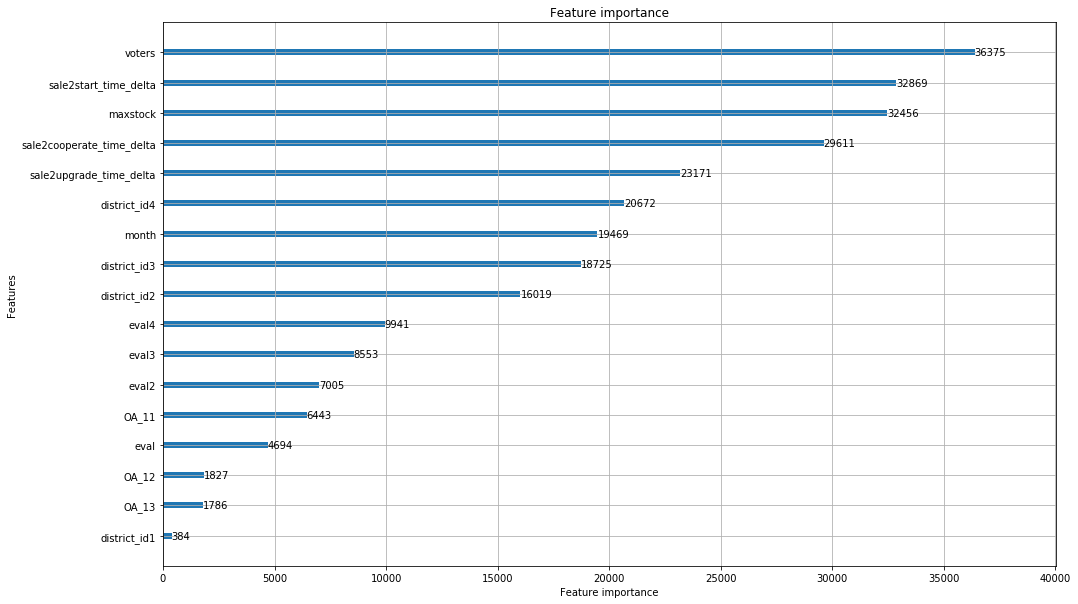

In [149]:
fig1 = plt.figure(figsize=(16,10))
ax1 = fig1.add_subplot(111)
lgb.plot_importance(lgb_model, max_num_features=50, ax=ax1)

### 4.2.3 rf model

In [150]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=200,
                                 criterion='mse',
                                 max_features=0.5, #default()
                                 max_depth=35,
                                 min_samples_split=2, #default(2)
                                 min_samples_leaf=1, #default(1)
                                 max_leaf_nodes=20000, #default(None)
                                 verbose=0,
                                 n_jobs=-1,
                                 random_state=seed)
# rf_model = RandomForestRegressor()
rf_model.fit(tr_x, tr_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features=0.5, max_leaf_nodes=20000,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=15,
           verbose=0, warm_start=False)

In [151]:
rf_vd_pred = rf_model.predict(vd_x)
# rf_vd_pred = np.exp(rf_vd_pred)-1  # this control whether the validate_y being transformed log
rf_vd_pred[rf_vd_pred<0] = 0
rf_vd_pred = np.round(rf_vd_pred)
vd_y = vd['ciiquantity'].fillna(0)
rmse_score = rmse(vd_y,rf_vd_pred)
rmse_score

160.4416471269307

In [152]:
rmse(vd_y,rf_vd_pred*1.2)

154.09402975303215

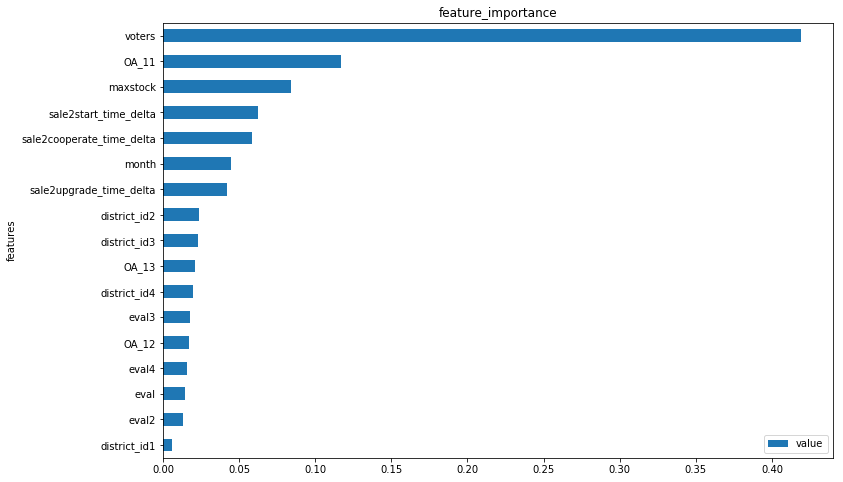

In [153]:
imp_features = pd.Series(rf_model.feature_importances_)

features_ranking = pd.DataFrame({'features': tr_x.columns[imp_features.sort_values().index],
                                 'value':imp_features.sort_values().values})

features_ranking.plot(x='features', y='value', kind='barh',figsize=(12,8),title='feature_importance')

### 4.2.4 融合（直接取均值）

In [154]:
forge_vd_pred = (lgb_vd_pred +xgb_vd_pred + rf_vd_pred)
forge_vd_pred[forge_vd_pred<0] =10
forge_vd_pred = np.round(forge_vd_pred)
vd_y = vd['ciiquantity'].fillna(0)
rmse_score = rmse(vd_y,forge_vd_pred)
rmse_score

411.1532403193257

### 4.2.5 predict

In [155]:
seeds = [[15,20,66],[49,314,255]]
pred_dict = {'xgb':[],
             'lgb':[],
             'rf':[]}
for j in range(1):
    for i in range(3):
        all_train = all_data[all_data['year_month'] < pd.to_datetime('2015-12-01')][features[i]]
        # all_train = all_data[(all_data['year_month'] < pd.to_datetime('2015-12-01'))&(all_data['year_month'] >= pd.to_datetime('2014-12-01'))][features[i]]
        all_train_weight = all_data[all_data['year_month'] < pd.to_datetime('2015-12-01')]['sample_weight'].values
        all_train_x = all_train.drop('ciiquantity',axis=1)
        all_train_y = all_train['ciiquantity'].fillna(0)
        test = all_data[all_data['year_month'] >= pd.to_datetime('2015-12-01')][features[i]]
        test_x = test.drop('ciiquantity',axis=1)
        print(j,i)
        xgb_params['seed'] = seeds[j][i]
        lgb_params['random_state'] = seeds[j][i]
        rf_model = RandomForestRegressor(n_estimators=200,
                                         criterion='mse',
                                         max_features=0.5, #default()
                                         max_depth=35,
                                         min_samples_split=2, #default(2)
                                         min_samples_leaf=1, #default(1)
                                         max_leaf_nodes=20000, #default(None)
                                         verbose=0,
                                         n_jobs=-1,
                                         random_state=seeds[j][i])
        print("========xgb==========")
#         xgb_train_all = xgb.DMatrix(all_train_x, all_train_y)
        xgb_train_all = xgb.DMatrix(all_train_x, all_train_y,weight=all_train_weight)
        xgb_train_all_model = xgb.train(xgb_params,xgb_train_all,num_boost_round=1000, verbose_eval=True)
        print("========rf==========")
#         rf_model.fit(all_train_x, all_train_y)
        rf_model.fit(all_train_x, all_train_y, all_train_weight)
        print("========lgb==========")
        lgb_train_all = lgb.Dataset(all_train_x, all_train_y,weight=all_train_weight)
#         lgb_train_all = lgb.Dataset(all_train_x, all_train_y)
        lgb_model = lgb.train(lgb_params, lgb_train_all, num_boost_round=5000)
        print('predicting')
        xgb_test_x = xgb.DMatrix(test_x)
        lgb_test_x =lgb.Dataset(test_x)
        all_xgb_pred = xgb_train_all_model.predict(xgb_test_x)
        all_rf_pred = rf_model.predict(test_x)
        all_lgb_pred = lgb_model.predict(test_x)
        pred_dict['xgb'].append(all_xgb_pred)
        pred_dict['lgb'].append(all_lgb_pred)
        pred_dict['rf'].append(all_rf_pred)

0 0
========xgb==========
========rf==========
========lgb==========
predicting
0 1
========xgb==========
========rf==========
========lgb==========
predicting
0 2
========xgb==========
========rf==========
========lgb==========
predicting


In [163]:
temp_test = test_data
for i in range(3):
    temp_test['xgb'+'{}'.format(i)] = pred_dict['xgb'][i]
    temp_test['lgb'+'{}'.format(i)] = pred_dict['lgb'][i]
    temp_test['rf'+'{}'.format(i)] = pred_dict['rf'][i]

In [164]:
temp_test['avg0'] = (temp_test['xgb0']+ temp_test['lgb0']+temp_test['rf0'])/3
temp_test['avg1'] = (temp_test['xgb1']+ temp_test['lgb1']+temp_test['rf1'])/3
temp_test['avg2'] = (0.4*temp_test['xgb2']+ 0.2*temp_test['lgb2']+0.2*temp_test['rf2'])
temp_test['avg3'] = (0.5*temp_test['avg0']+ 0.5*temp_test['avg2'])
temp_test['avg5'] = (0.6*temp_test['avg0']+ 0.2*temp_test['avg1']+0.2*temp_test['avg2'])

In [165]:
temp_test.head()

,product_id,year_month,xgb0,lgb0,rf0,xgb1,lgb1,rf1,xgb2,lgb2,rf2,avg0,avg1,avg2,avg3,avg5
0,1,2015-12-01,61.248989,43.599145,87.594212,53.241417,32.758359,84.640990,62.774414,52.455981,86.859927,64.147449,56.880255,52.972948,58.560198,60.459110
1,2,2015-12-01,123.306175,154.623524,199.318928,155.938416,173.098789,199.926500,176.986710,197.083834,166.645798,159.082876,176.321235,143.540612,151.311744,159.422095
2,3,2015-12-01,180.093369,289.397432,311.030347,210.007858,320.270672,299.746013,213.491257,249.319204,241.391226,260.173716,276.674848,183.538593,221.856155,248.146918
3,4,2015-12-01,89.292366,91.529799,85.373584,92.437653,108.327960,94.830328,101.543182,128.969821,92.735617,88.731917,98.531980,84.958363,86.845140,89.937219
4,5,2015-12-01,92.009277,85.854467,114.169800,122.449821,113.694227,143.156677,125.286674,120.053381,146.463269,97.344515,126.433575,103.418000,100.381257,104.377024


In [166]:
pred = temp_test.avg5.values

In [167]:
submit = all_data[all_data['year_month'] >= pd.to_datetime('2015-12-01')][['product_id', 'year_month']]
submit['ciiquantity_month'] = np.round(pred*1.1).astype(int)
submit['product_id'] = submit.product_id.apply(lambda x:int(x))
submit['ciiquantity_month'] = submit['ciiquantity_month'].apply(lambda x: 10 if x<0 else x)
submit.sort_values(['year_month', 'product_id'], inplace=True)
submit.rename(columns={'year_month': 'product_month'}, inplace=True)
submit.head()

,product_id,product_month,ciiquantity_month
60557,1,2015-12-01,67
60558,2,2015-12-01,175
60559,3,2015-12-01,273
60560,4,2015-12-01,99
60561,5,2015-12-01,115


In [168]:
submit.ix[submit.product_id.isin(no_sales_prod),'ciiquantity_month'] = submit.ix[submit.product_id.isin(no_sales_prod),'ciiquantity_month']+20

In [169]:
submit.to_csv('best_result.csv', index=False)